# 0. Информация об видеокарте.

In [1]:
!nvidia-smi

Tue Apr 16 00:59:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.06              Driver Version: 545.29.06    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P3              11W /  30W |      7MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# 1. Загурзка библиотек и объявление путей

In [2]:
import os
import glob
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import json
from pprint import pprint
import requests
import rarfile
import zipfile
import yaml
from ultralytics import YOLO

import warnings
warnings.filterwarnings("ignore")

/home/k1rsn7/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


#### Список датасетов и названий директорий в директории DATASETS:

     СarDetection 
     https://www.kaggle.com/datasets/sshikamaru/car-object-detection
     
     CarsDetection 
     https://www.kaggle.com/datasets/abdallahwagih/cars-detection/data
     
     CarPerson
     https://www.kaggle.com/datasets/owaiskhan9654/car-person-v2-roboflow
     
     STN 
     https://github.com/andreluizbvs/PLAD/releases/download/1.0/plad.zip

     UtilityPole
     https://github.com/R3ab/ttpla_dataset?tab=readme-ov-file
     
     Transmission
     https://drive.usercontent.google.com/download?id=1Yz59yXCiPKS0_X4K3x9mW22NLnxjvrr0&export=download&authuser=0
     
     Tree
     https://universe.roboflow.com/tank-detect/tree-dataset-owarv
     
     TreeDetection 
     https://universe.roboflow.com/yolo-for-tree-detection/tree-detection-by-season-type
     
     Trees100
     https://universe.roboflow.com/dataset-x4ge5/dataset_trees_100_images
     
     BirdAnnotation
     https://universe.roboflow.com/drone-when8/bird-annotation-drp1n/dataset/1
     
     BirdsDetector
     https://universe.roboflow.com/jess-minaya/birds-detector-tis9s/dataset/1
     
     BirdsV3 
     https://universe.roboflow.com/kurisnis/birds-olyak/dataset/3
     
     BuildingDetection
     https://universe.roboflow.com/david-wardan/buildingdetection/dataset/1/images?split=test
     
     JoshEdits
     https://universe.roboflow.com/tour-de-chicago/josh-edits-2.5-outterclassifier

In [3]:
# Пути до датасетов с автомобилями
PATH_CAR = '../data/DATASET/CarDetection' # Путь до датасета Car Detection
PATH_CARS = '../data/DATASET/CarsDetection/Cars Detection/' # Путь до датасета Cars Detection
PATH_CAR_PERSON = '../data/DATASET/CarPerson/Car-Person-v2-Roboflow-Owais-Ahmad/' # Путь до датасета Car Person

# Пути до датасетов с ЛЭП
PATH_STN = '../data/DATASET/STN' # Путь до датасета STN PLAD
PATH_UTILLUTY_POLE = '../data/DATASET/UtilityPole/' # Путь до датасета Utiluty Pole
PATH_TRANSMISSION = '../data/DATASET/Transmission/data_original_size_v1/data_original_size/' # Путь до датасета Transmission

# Пути до датасетов с деревьями
PATH_TREE = '../data/DATASET/Tree/' # Путь до датасета Tree Detection
PATH_TREE_DETECTION = '../data/DATASET/TreeDetection/' # Путь до датасета Tree Detection
PATH_TREE_100 = '../data/DATASET/Trees100/' # Путь до датасета Tree 100

# Пути до датасетов с птицами
PATH_BIRD_ANNOTATION = '../data/DATASET/BirdAnnotation/' # Путь до датасета Bird Annotation 
PATH_BIRDS_DETECTOR = '../data/DATASET/BirdsDetector/' # Путь до датасета Birds Detector
PATH_BIRDS_V3 = '../data/DATASET/BirdsV3/' # Путь до датасета BirdsV3

# Пути до датасетов со зданиями
PATH_BUILDING_DETECTION = '../data/DATASET/BuildingDetection/' # Путь до датасета Building Detection
PATH_JOSH_EDITS = '../data/DATASET/JoshEdits/' # Путь до датасета JoshEdits

# Словарь по понижению размрености датасетов
DATASET_DOWNGRADES = {
    'dataCarDetection': 2, 
    'dataCarPerson': 3, 
    'dataCarsDetection': 4,
    'dataSTN': 1, 
    'dataUnilityPole': 1, 
    'dataTransmission': 1,
    'dataTree': 2, 
    'dataTreeDetection': 2, 
    'dataTree100': 2,
    'dataBirdAnnotation': 4, 
    'dataBirdsDetectod': 4, 
    'dataBirdsV3': 2,
    'dataBuildingDetection': 2, 
    'dataJoshEdits': 2
}

# 2. Обработка данных

In [4]:
def print_variable_name(variable):
    '''
        Функция позволяет получить имя переменной
        Input: 
            variable - переменная
        Output:
            variable_name - имя переменной
    '''
    variable_name = [name for name, value in globals().items() if value is variable][-1]
    return variable_name

In [5]:
def converterYoloToDataFrame(labels_list, path, classes):
    '''
        Функция позволяет перенести все данные с формата YOLO в DataFrame
        Input:
            labels_list - набор названий изображений
            path - путь до папки с изображениями
    '''
    labels = {} # Словарь объктов
    number_item = 0 # Номер записи
    for item in tqdm(labels_list):
        # Читаем все записи
        with open(path + item) as f:
            lines = f.readlines()
    
        # Проходимся по каждой записи
        for line in lines:
            # Получаем координаты в процентах
            x_center, y_center, w, h = (float(number) for number in line.split()[1:]) 
    
            # Заносим в словарь
            labels[number_item] = {
                'image_name': '/'.join(path.split('/')[:-2]) + '/images/' + item[:-3] + 'jpg',
                'x_center': x_center, 
                'y_center': y_center, 
                'w': w, 
                'h': h,
                'classes': classes
            }
            number_item += 1
    return labels

In [6]:
def datasetMinimization(dataSet, count):
    '''
        Функция позволяет понизить размер DataFrame за счёт удаления фотографий
        Input:
            dataSet - первоначальный DataFrame
            count - количество, во сколько раз сжать DataFrame
    '''
    # Список во всеми именами фотографий
    list_image_name = dataSet['image_name'].unique().tolist()

    # Кол-во фотографий в начале
    start_count_image = len(list_image_name)
    
    # Получаем именя изображений, которые оставляем
    name_file = random.sample(list_image_name, len(list_image_name) // count)

    # Записи с этими файлами
    dataSet = dataSet[dataSet['image_name'].isin(name_file)]

    # Кол-во фотографий после обработки
    end_count_image = len(dataSet['image_name'].unique())
    
    # Выведем системноо сообщение об результате сокращения фотографий
    print(f'There were {start_count_image} photos, now there are {end_count_image}')
    
    return dataSet

## 2.0 Классы для модели
    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

## 2.1. Датасеты с автомобилями
### 2.1.1 Обработка датасета Car Detection

In [7]:
img_h, img_w = (380, 676) # Размеры изображения
dataCarDetection = pd.read_csv(PATH_CAR + '/train_solution_bounding_boxes (1).csv') # Читаем датасет

dataCarDetection.rename(columns={'image':'image_name'}, inplace=True) # Переименовываем колонку

dataCarDetection.sample(10) # посмотрим на данные

,image_name,xmin,ymin,xmax,ymax
144,vid_4_17160.jpg,290.063676,192.903797,409.415340,234.962999
387,vid_4_30020.jpg,11.739508,194.370978,76.306802,225.181789
376,vid_4_29920.jpg,382.023155,181.655405,553.713459,260.394144
327,vid_4_26440.jpg,582.573083,177.742921,676.000000,218.334942
535,vid_4_9640.jpg,257.992717,185.031574,386.989075,241.145564
305,vid_4_26360.jpg,337.510854,185.567889,460.775687,232.028636
17,vid_4_11020.jpg,0.000000,197.794401,75.817656,237.408301
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
341,vid_4_26460.jpg,473.493488,185.567889,573.279305,227.138031
377,vid_4_29920.jpg,642.248915,180.188224,676.000000,202.685006


In [8]:
# Получим координаты центра объекта в процентах 
dataCarDetection['x_center'] = (dataCarDetection['xmin'] + dataCarDetection['xmax']) / 2 / img_w 
dataCarDetection['y_center'] = (dataCarDetection['ymin'] + dataCarDetection['ymax']) / 2 / img_h 

# Получим размеры объекта в процентах
dataCarDetection['w'] = (dataCarDetection['xmax'] - dataCarDetection['xmin']) / img_w # Получаем ширину объекта в процентах
dataCarDetection['h'] = (dataCarDetection['ymax'] - dataCarDetection['ymin']) / img_h # Получаем ширину объекта в процентах
dataCarDetection['classes'] = 0 # Задаём класс объекта
dataCarDetection.drop(
    ['xmin', 'xmax', 'ymin', 'ymax'], # Удаляем ненужные признаки
    axis=1, inplace=True
)

# Изменим путь до файла
dataCarDetection['image_name'] = f'{PATH_CAR}/training_images/' + dataCarDetection['image_name']

# Очистим память 
del img_h, img_w

# Уменьшаем размер DataFrame
dataCarDetection = datasetMinimization(dataCarDetection, DATASET_DOWNGRADES[print_variable_name(dataCarDetection)])

dataCarDetection.sample(10) # Посмотрим на данные

There were 355 photos, now there are 177


,image_name,x_center,y_center,w,h,classes
254,../data/DATASET/CarDetection/training_images/v...,0.304993,0.555904,0.125181,0.086229,0
82,../data/DATASET/CarDetection/training_images/v...,0.308973,0.516007,0.057887,0.065637,0
193,../data/DATASET/CarDetection/training_images/v...,0.145441,0.566200,0.173661,0.127413,0
81,../data/DATASET/CarDetection/training_images/v...,0.162084,0.583575,0.211288,0.149292,0
474,../data/DATASET/CarDetection/training_images/v...,0.742535,0.529024,0.184268,0.107513,0
76,../data/DATASET/CarDetection/training_images/v...,0.810420,0.520512,0.214182,0.126126,0
309,../data/DATASET/CarDetection/training_images/v...,0.335745,0.561052,0.164978,0.096525,0
554,../data/DATASET/CarDetection/training_images/v...,0.036417,0.571770,0.072833,0.099741,0
487,../data/DATASET/CarDetection/training_images/v...,0.585215,0.538091,0.108521,0.086788,0
216,../data/DATASET/CarDetection/training_images/v...,0.187410,0.555904,0.124457,0.111969,0


## 2.1.2. Обработка датасета Cars Detection

In [9]:
dataCarsDetection = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_CARS}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_CARS}{sample}/labels/', 0)) # Получаем датасет с разметкой
    dataCarsDetection = pd.concat([dataCarsDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataCarsDetection = datasetMinimization(dataCarsDetection, DATASET_DOWNGRADES[print_variable_name(dataCarsDetection)])

dataCarsDetection.sample(10) # Посмотрим на данные

  0%|          | 0/878 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

There were 1254 photos, now there are 313


,image_name,x_center,y_center,w,h,classes
528,../data/DATASET/CarsDetection/Cars Detection/t...,0.504808,0.479567,0.908654,0.891827,0
398,../data/DATASET/CarsDetection/Cars Detection/v...,0.514423,0.492788,0.967548,0.777644,0
872,../data/DATASET/CarsDetection/Cars Detection/t...,0.574519,0.209135,0.170673,0.112981,0
127,../data/DATASET/CarsDetection/Cars Detection/t...,0.110577,0.639423,0.204327,0.15625,0
201,../data/DATASET/CarsDetection/Cars Detection/v...,0.383413,0.415865,0.759615,0.651442,0
250,../data/DATASET/CarsDetection/Cars Detection/t...,0.498798,0.496394,0.96274,0.973558,0
319,../data/DATASET/CarsDetection/Cars Detection/t...,0.701923,0.502404,0.332933,0.810096,0
165,../data/DATASET/CarsDetection/Cars Detection/t...,0.478365,0.027644,0.240385,0.055288,0
62,../data/DATASET/CarsDetection/Cars Detection/t...,0.515625,0.496394,0.860577,0.935096,0
378,../data/DATASET/CarsDetection/Cars Detection/v...,0.695913,0.449519,0.539663,0.609375,0


### 2.1.3. Обработка датасета Car Person

In [10]:
dataCarPerson = pd.DataFrame(columns=dataCarDetection.columns)
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_CAR_PERSON}{sample}/labels') # Список файлов с разметкой
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_CAR_PERSON}{sample}/labels/', 0)) # Получаем датасет с разметкой
    dataCarPerson = pd.concat([dataCarPerson, labels.T]) # Соединяем выборки в единый датасет
    
del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataCarPerson = datasetMinimization(dataCarPerson, DATASET_DOWNGRADES[print_variable_name(dataCarPerson)])

dataCarPerson.sample(10) # Посмотрим на данные

  0%|          | 0/1571 [00:00<?, ?it/s]

  0%|          | 0/448 [00:00<?, ?it/s]

  0%|          | 0/224 [00:00<?, ?it/s]

There were 2243 photos, now there are 747


,image_name,x_center,y_center,w,h,classes
2946,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.09375,0.225962,0.082933,0.09375,0
919,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.854567,0.514423,0.040865,0.026442,0
858,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.995192,0.304087,0.007212,0.058894,0
6038,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.674279,0.661058,0.08774,0.388221,0
4298,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.610577,0.520433,0.777644,0.77524,0
2350,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.584135,0.759615,0.540865,0.415865,0
6002,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.414663,0.408654,0.064904,0.167067,0
279,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.530048,0.298077,0.048077,0.225962,0
733,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.115385,0.680288,0.009615,0.081731,0
2685,../data/DATASET/CarPerson/Car-Person-v2-Robofl...,0.137019,0.513221,0.171875,0.08774,0


## 2.2. Обработка датасет с ЛЭП
### 2.2.1 Обработка датасета STN_PLAD

In [11]:
# Читаем файл с разметкой датасета STN
with open(PATH_STN + '/annotations.json') as f:
    dataSTN = json.load(f)

pprint(dataSTN['categories']) # Посмотрим на категории

# Получим два DataFrame, один с изображениями, другой с разметкой объектов
data = pd.DataFrame(dataSTN['images']).rename(columns={'id': 'image_id'})
data1 =  pd.DataFrame(dataSTN['annotations'])

# Объединим два дасатсета и удалим лишние признаки
dataSTN = pd.merge(data, data1, on='image_id', how='left').drop(
    [
        'licence', 'segmentation', 'date_captured', 'coco_url', 
        'iscrowd', 'image_id'
    ], axis=1
)

# Очистим память 
del data, data1 

dataSTN.sample(10) # Посмотрим на данные

[{'id': 0, 'name': 'tower', 'supercategory': 'tower'},
 {'id': 1, 'name': 'insulator', 'supercategory': 'component'},
 {'id': 2, 'name': 'spacer', 'supercategory': 'component'},
 {'id': 3, 'name': 'damper', 'supercategory': 'component'},
 {'id': 5, 'name': 'plate', 'supercategory': 'component'}]


,file_name,height,width,flickr_url,area,bbox,category_id,id
991,20181129-R/DJI_0018.JPG,3648,5472,,1403,"[4067, 1927, 61, 23]",3,996
577,20181129-R/DJI_0010.JPG,3648,5472,,49875,"[2198, 2321, 75, 665]",1,579
1198,20181127-A1/DJI_0503.JPG,3078,5472,,14490,"[2729, 2006, 126, 115]",2,1204
2236,20181127-A1/DJI_0415.JPG,3078,5472,,12920,"[2933, 1736, 152, 85]",3,2249
408,20181127-A1/DJI_0482.JPG,3078,5472,,8694,"[3642, 1067, 63, 138]",2,409
1203,20181127-A1/DJI_0503.JPG,3078,5472,,1088,"[2823, 2218, 17, 64]",3,1209
480,20181127-A1/DJI_0459.JPG,3078,5472,,4841,"[2284, 1384, 47, 103]",2,482
2292,20181127-A1/DJI_0477.JPG,3078,5472,,1728,"[3204, 1328, 64, 27]",3,2305
602,20181127-A1/DJI_0484.JPG,3078,5472,,14507,"[1634, 777, 163, 89]",2,605
951,20181129-R/DJI_0019.JPG,3648,5472,,4560,"[1771, 2350, 95, 48]",3,956


In [12]:
# Получим координаты объекта
dataSTN[['xmin', 'ymin', 'xmax', 'ymax']] = dataSTN['bbox'].apply(lambda x: pd.Series(x))
dataSTN['xmax'] = dataSTN['xmax'] + dataSTN['xmin']
dataSTN['ymax'] = dataSTN['ymax'] + dataSTN['ymin']

# Получим координаты центра объекта в процентах 
dataSTN['x_center'] = (dataSTN['xmin'] + dataSTN['xmax']) / 2 / dataSTN['width']
dataSTN['y_center'] = (dataSTN['ymin'] + dataSTN['ymax']) / 2 / dataSTN['height']

# Получим размеры объекта в процентах
dataSTN['w'] = (dataSTN['xmax'] - dataSTN['xmin']) / dataSTN['width']
dataSTN['h'] = (dataSTN['ymax'] - dataSTN['ymin']) / dataSTN['height']

# Переименуем признаки
dataSTN.rename(
    columns={
        'file_name': 'image_name',
        'category_id': 'classes'
    }, 
    inplace=True
) 

# Удалим ненужные признаки
dataSTN.drop(
    [
        'height', 'width', 'flickr_url',
        'area', 'bbox', 'id', 'xmin', 
        'xmax', 'ymin', 'ymax'
    ], 
    axis=1, inplace=True
)

# Изменим путь до файла
dataSTN['image_name'] = PATH_STN + '/' + dataSTN['image_name']

# Оставим фотографии принадлижащие только к опоре ЛЭП
dataSTN = dataSTN[dataSTN['classes'] == 0]
dataSTN['classes'] = dataSTN['classes'] + 1

dataSTN.sample(10) # Посомтрим на данные

,image_name,classes,x_center,y_center,w,h
1508,../data/DATASET/STN/20181127-A1/DJI_0428.JPG,1,0.515716,0.500162,0.119883,0.999675
938,../data/DATASET/STN/20181129-R/DJI_0019.JPG,1,0.451480,0.406935,0.010417,0.072643
69,../data/DATASET/STN/20181129-R/DJI_0024.JPG,1,0.154423,0.190378,0.025585,0.074836
206,../data/DATASET/STN/20181127-A1/DJI_0462.JPG,1,0.336623,0.578622,0.043860,0.626381
315,../data/DATASET/STN/20181127-A1/DJI_0438.JPG,1,0.470577,0.585283,0.082968,0.829435
300,../data/DATASET/STN/20181127-A1/DJI_0429.JPG,1,0.236020,0.220598,0.092654,0.440546
1961,../data/DATASET/STN/20181129-R/DJI_0004.JPG,1,0.137061,0.175439,0.043860,0.101974
863,../data/DATASET/STN/20181127-A1/DJI_0492.JPG,1,0.465278,0.674951,0.555556,0.650097
0,../data/DATASET/STN/20181129-R/DJI_0021.JPG,1,0.563962,0.534265,0.260234,0.931469
839,../data/DATASET/STN/20181127-A1/DJI_0418.JPG,1,0.868787,0.310916,0.030702,0.127355


### 2.2.2. Обработка датасета Utility Pole

In [13]:
dataUnilityPole = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'test']:
    labels_name = os.listdir(f'{PATH_UTILLUTY_POLE}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_UTILLUTY_POLE}{sample}/labels/', 1)) # Получаем датасет с разметкой
    dataUnilityPole = pd.concat([dataUnilityPole, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память
dataUnilityPole.sample(10) # Посмотрим на данные

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
152,../data/DATASET/UtilityPole/train/images/up1_j...,0.614183,0.492788,0.233173,0.836538,1
68,../data/DATASET/UtilityPole/train/images/stree...,0.432692,0.550481,0.235577,0.894231,1
245,../data/DATASET/UtilityPole/train/images/Cisco...,0.353365,0.652644,0.192308,0.675481,1
252,../data/DATASET/UtilityPole/train/images/stree...,0.432692,0.550481,0.235577,0.894231,1
163,../data/DATASET/UtilityPole/train/images/distr...,0.6875,0.776442,0.072115,0.259615,1
101,../data/DATASET/UtilityPole/train/images/twup_...,0.823317,0.626202,0.112981,0.175481,1
135,../data/DATASET/UtilityPole/train/images/_w850...,0.626202,0.502404,0.189904,0.990385,1
146,../data/DATASET/UtilityPole/train/images/woode...,0.786058,0.569712,0.221154,0.735577,1
164,../data/DATASET/UtilityPole/train/images/Inter...,0.430288,0.415865,0.221154,0.668269,1
20,../data/DATASET/UtilityPole/train/images/Doubl...,0.415865,0.563702,0.139423,0.680288,1


### 2.2.3. Обработка датасета Transmission

In [14]:
list_image = glob.glob(PATH_TRANSMISSION + '*.jpg')
labels = {} # Словарь объктов
number_item = 0 # Номер записи
for path_image in tqdm(list_image):
    with open(path_image[:-3] + 'json') as f:
        json_file = json.load(f)
    xmax = 0
    xmin = 2**10
    ymax = 0
    ymin = 2**10
    height = json_file['imageHeight']
    width = json_file['imageWidth']
    for item in json_file['shapes']:
        if item['label'] in ['tower_wooden', 'cable']:
            for data in item['points']:
                x, y = data
                xmax = x if x > xmax else xmax
                ymax = y if x > ymax else ymax
                xmin = x if y < xmin else xmin
                ymin = y if y < ymin else ymin
            x_center = (xmin + xmax) / 2 / width
            y_center = (ymin + ymax) / 2 / height
            w = (xmax - xmin) / width
            h = (ymax - ymin) / height
            labels[number_item] = {
                'image_name': path_image,
                'x_center': 0.0 if x_center < 0.0 else 1.0 if x_center > 1.0 else x_center, 
                'y_center': 0.0 if y_center < 0.0 else 1.0 if y_center > 1.0 else x_center, 
                'w': 0.0 if w < 0.0 else 1.0 if w > 1.0 else w, 
                'h': 0.0 if h < 0.0 else 1.0 if h > 1.0 else h,
                'classes': 1 if item['label'] == 'tower_wooden' else 5
            }
            number_item += 1
            
dataTransmission = pd.DataFrame(labels).T # Переносим все в DataFrame

# Очищаем память
del list_image, labels, number_item, xmin, xmax, ymin, ymax, h, w, json_file 

# Уменьшаем размер DataFrame
dataTransmission = datasetMinimization(dataTransmission, DATASET_DOWNGRADES[print_variable_name(dataTransmission)])

dataTransmission.sample(10) # Посмотрим на данные

  0%|          | 0/1242 [00:00<?, ?it/s]

There were 1231 photos, now there are 1231


,image_name,x_center,y_center,w,h,classes
7916,../data/DATASET/Transmission/data_original_siz...,0.499512,0.499512,0.999023,0.110026,5
3012,../data/DATASET/Transmission/data_original_siz...,0.49987,0.49987,0.99974,0.369581,5
8096,../data/DATASET/Transmission/data_original_siz...,0.702574,0.702574,0.594331,0.198382,5
6939,../data/DATASET/Transmission/data_original_siz...,0.778496,0.778496,0.13989,0.808998,5
1861,../data/DATASET/Transmission/data_original_siz...,0.850963,0.850963,0.297059,0.080711,5
1829,../data/DATASET/Transmission/data_original_siz...,0.972792,0.972792,0.053894,0.721972,5
10164,../data/DATASET/Transmission/data_original_siz...,0.597131,0.597131,0.556926,0.659925,5
4330,../data/DATASET/Transmission/data_original_siz...,0.566547,0.566547,0.864953,0.035862,5
1375,../data/DATASET/Transmission/data_original_siz...,0.499512,0.499512,0.999023,0.644877,5
4352,../data/DATASET/Transmission/data_original_siz...,0.474419,0.474419,0.183974,0.769349,5


## 2.3. Обработка датасетов с деревьями
### 2.3.1. Обработка датасета Tree Object Detecion

In [15]:
dataTree = pd.DataFrame(columns=dataCarDetection.columns)
labels_name = os.listdir(f'{PATH_TREE}train/labels/') # Список файлов с разметкой
labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE}train/labels/', 2)) # Получаем датасет с разметкой
dataTree = pd.concat([dataTree, labels.T]) # Соединяем выборки в единый датасет
    
del labels_name, labels # Очищаем память

dataTree.sample(10) # Посмотрим на данные

  0%|          | 0/214 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
280,../data/DATASET/Tree/train/images/RGXRFD_jpg.r...,0.223438,0.725,0.070312,0.065625,2
487,../data/DATASET/Tree/train/images/josh-miller-...,0.530469,0.574219,0.742188,0.851562,2
234,../data/DATASET/Tree/train/images/6214799472_0...,0.970313,0.707031,0.059375,0.214062,2
46,../data/DATASET/Tree/train/images/sacramento_s...,0.236719,0.479687,0.248438,0.40625,2
511,../data/DATASET/Tree/train/images/3888_jpg.rf....,0.884375,0.815625,0.035937,0.096875,2
306,../data/DATASET/Tree/train/images/images-58-_j...,0.648438,0.521875,0.159375,0.628125,2
215,../data/DATASET/Tree/train/images/TCC-2021_jpg...,0.400781,0.545312,0.742188,0.867188,2
103,../data/DATASET/Tree/train/images/istockphoto-...,0.5,0.5,1.0,1.0,2
362,../data/DATASET/Tree/train/images/landscape-55...,0.43125,0.470313,0.860938,0.940625,2
13,../data/DATASET/Tree/train/images/big-tree-pix...,0.782031,0.889844,0.042188,0.173437,2


### 2.3.2. Обработка датасета TreeDetection 

In [16]:
dataTreeDetection = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_TREE_DETECTION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE_DETECTION}{sample}/labels/', 2)) # Получаем датасет с разметкой
    dataTreeDetection = pd.concat([dataTreeDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataTreeDetection = datasetMinimization(dataTreeDetection, DATASET_DOWNGRADES[print_variable_name(dataTreeDetection)])

dataTreeDetection.sample(10) # Посмотрим на данные

  0%|          | 0/1803 [00:00<?, ?it/s]

  0%|          | 0/174 [00:00<?, ?it/s]

  0%|          | 0/86 [00:00<?, ?it/s]

There were 2060 photos, now there are 1030


,image_name,x_center,y_center,w,h,classes
2498,../data/DATASET/TreeDetection/train/images/230...,0.438281,0.68125,0.11875,0.305469,2
211,../data/DATASET/TreeDetection/valid/images/9f8...,0.38125,0.500781,0.748437,0.989844,2
2837,../data/DATASET/TreeDetection/train/images/021...,0.423438,0.5375,0.353125,0.2125,2
2812,../data/DATASET/TreeDetection/train/images/aac...,0.471875,0.683594,0.24375,0.6125,2
823,../data/DATASET/TreeDetection/train/images/211...,0.267188,0.560156,0.43125,0.728125,2
108,../data/DATASET/TreeDetection/test/images/480f...,0.399219,0.510156,0.25,0.489063,2
3175,../data/DATASET/TreeDetection/train/images/a37...,0.474219,0.482812,0.850781,0.825,2
3067,../data/DATASET/TreeDetection/train/images/210...,0.453906,0.875781,0.548438,0.220312,2
1827,../data/DATASET/TreeDetection/train/images/211...,0.371094,0.36875,0.085938,0.175,2
202,../data/DATASET/TreeDetection/train/images/86e...,0.54375,0.502344,0.90625,0.995313,2


### 2.3.3. Обработка датасета Tree 100

In [17]:
dataTree100 = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_TREE_100}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_TREE_100}{sample}/labels/', 2)) # Получаем датасет с разметкой
    dataTree100 = pd.concat([dataTree100, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

dataTree100.sample(10) # Посмотрим на данные

  0%|          | 0/82 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

,image_name,x_center,y_center,w,h,classes
153,../data/DATASET/Trees100/train/images/arvore93...,0.509375,0.400781,0.772656,0.578125,2
145,../data/DATASET/Trees100/train/images/arvore92...,0.570312,0.664062,0.051562,0.065625,2
5,../data/DATASET/Trees100/train/images/arvore96...,0.4625,0.580469,0.058594,0.06875,2
104,../data/DATASET/Trees100/train/images/arvore30...,0.502344,0.488281,0.75625,0.821094,2
51,../data/DATASET/Trees100/train/images/arvore94...,0.489844,0.451562,0.75,0.798438,2
110,../data/DATASET/Trees100/train/images/arvore40...,0.532813,0.664062,0.040625,0.050781,2
19,../data/DATASET/Trees100/valid/images/arvore27...,0.516406,0.488281,0.626563,0.700781,2
37,../data/DATASET/Trees100/train/images/arvore11...,0.464844,0.786719,0.0875,0.308594,2
125,../data/DATASET/Trees100/train/images/arvore97...,0.350781,0.808594,0.138281,0.382031,2
140,../data/DATASET/Trees100/train/images/arvore73...,0.342187,0.685937,0.123438,0.334375,2


## 2.4. Обработка датасета с птицами
### 2.4.1. Обработка датасета с Bird Annotation

In [18]:
dataBirdAnnotation = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRD_ANNOTATION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRD_ANNOTATION}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdAnnotation  = pd.concat([dataBirdAnnotation, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataBirdAnnotation = datasetMinimization(dataBirdAnnotation, DATASET_DOWNGRADES[print_variable_name(dataBirdAnnotation)])

dataBirdAnnotation.sample(10) # Посмотрим на данные

  0%|          | 0/1362 [00:00<?, ?it/s]

  0%|          | 0/130 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

There were 1557 photos, now there are 389


,image_name,x_center,y_center,w,h,classes
15685,../data/DATASET/BirdAnnotation/train/images/vo...,0.891406,0.371875,0.035937,0.040625,3
4934,../data/DATASET/BirdAnnotation/train/images/vo...,0.5875,0.5,0.825,1.0,3
9620,../data/DATASET/BirdAnnotation/train/images/vo...,0.572656,0.629687,0.045312,0.04375,3
10730,../data/DATASET/BirdAnnotation/train/images/vo...,0.586719,0.660937,0.057813,0.039062,3
16546,../data/DATASET/BirdAnnotation/train/images/e1...,0.676562,0.723437,0.070312,0.090625,3
8131,../data/DATASET/BirdAnnotation/train/images/e2...,0.921094,0.44375,0.01875,0.014063,3
12180,../data/DATASET/BirdAnnotation/train/images/de...,0.567187,0.489063,0.065625,0.076563,3
544,../data/DATASET/BirdAnnotation/train/images/e1...,0.64375,0.689844,0.051562,0.064062,3
18448,../data/DATASET/BirdAnnotation/train/images/pa...,0.054688,0.449219,0.015625,0.023438,3
2704,../data/DATASET/BirdAnnotation/train/images/vo...,0.259375,0.626563,0.070312,0.048438,3


### 2.4.2. Обработка датасета с Birds Detection

In [19]:
dataBirdsDetectod = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRDS_DETECTOR}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRDS_DETECTOR}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdsDetectod = pd.concat([dataBirdsDetectod, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataBirdsDetectod = datasetMinimization(dataBirdsDetectod, DATASET_DOWNGRADES[print_variable_name(dataBirdsDetectod)])

dataBirdsDetectod.sample(10)  # Посмотрим на данные

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/170 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

There were 849 photos, now there are 212


,image_name,x_center,y_center,w,h,classes
411,../data/DATASET/BirdsDetector/train/images/des...,0.826562,0.595313,0.089063,0.0625,3
2769,../data/DATASET/BirdsDetector/train/images/des...,0.35625,0.755469,0.051562,0.149219,3
3170,../data/DATASET/BirdsDetector/train/images/vol...,0.653906,0.388281,0.046875,0.054688,3
2265,../data/DATASET/BirdsDetector/train/images/paj...,0.138281,0.426563,0.2125,0.199219,3
1411,../data/DATASET/BirdsDetector/valid/images/vol...,0.55625,0.270313,0.042188,0.067187,3
2940,../data/DATASET/BirdsDetector/train/images/vol...,0.550781,0.527344,0.15625,0.121875,3
1666,../data/DATASET/BirdsDetector/train/images/vol...,0.594531,0.483594,0.025781,0.054688,3
344,../data/DATASET/BirdsDetector/test/images/e286...,0.457813,0.453906,0.408594,0.479687,3
936,../data/DATASET/BirdsDetector/valid/images/e11...,0.271875,0.6,0.030469,0.042969,3
843,../data/DATASET/BirdsDetector/train/images/Pal...,0.514062,0.452344,0.811719,0.8125,3


### 2.4.3. Обработка датасета с BirdsV3

In [20]:
dataBirdsV3 = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BIRDS_V3}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BIRDS_V3}{sample}/labels/', 3)) # Получаем датасет с разметкой
    dataBirdsV3 = pd.concat([dataBirdsV3, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataBirdsV3 = datasetMinimization(dataBirdsV3, DATASET_DOWNGRADES[print_variable_name(dataBirdsV3)])

dataBirdsV3.sample(10)  # Посмотрим на данные

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

There were 665 photos, now there are 332


,image_name,x_center,y_center,w,h,classes
412,../data/DATASET/BirdsV3/train/images/Pigeons-o...,0.210938,0.525781,0.05,0.065625,3
453,../data/DATASET/BirdsV3/train/images/birds-on-...,0.369531,0.542969,0.025,0.032813,3
33,../data/DATASET/BirdsV3/test/images/birds-sitt...,0.267188,0.594531,0.026562,0.0375,3
1032,../data/DATASET/BirdsV3/train/images/pvNUQtu_j...,0.759375,0.876563,0.110937,0.204687,3
3082,../data/DATASET/BirdsV3/train/images/can-i-sho...,0.844531,0.735938,0.078125,0.1125,3
272,../data/DATASET/BirdsV3/train/images/pigeons-t...,0.886719,0.374219,0.05,0.070312,3
818,../data/DATASET/BirdsV3/train/images/Bird-Remo...,0.453906,0.338281,0.0625,0.060937,3
3535,../data/DATASET/BirdsV3/train/images/pigeons_o...,0.649219,0.75,0.017188,0.034375,3
367,../data/DATASET/BirdsV3/valid/images/pigeons-o...,0.727344,0.426563,0.03125,0.0375,3
77,../data/DATASET/BirdsV3/test/images/3-steps-to...,0.321875,0.310156,0.189062,0.225781,3


## 2.5. Обработка фотографий со зданиями
### 2.5.1. Обработка датасета Building Detection 

In [21]:
dataBuildingDetection = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_BUILDING_DETECTION}{sample}/labels') # Список файлов с разметкой 
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_BUILDING_DETECTION}{sample}/labels/', 4)) # Получаем датасет с разметкой
    dataBuildingDetection = pd.concat([dataBuildingDetection, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataBuildingDetection = datasetMinimization(dataBuildingDetection, DATASET_DOWNGRADES[print_variable_name(dataBuildingDetection)])

dataBuildingDetection.sample(10)  # Посмотрим на данные

  0%|          | 0/726 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

There were 802 photos, now there are 401


,image_name,x_center,y_center,w,h,classes
659,../data/DATASET/BuildingDetection/train/images...,0.498798,0.502404,0.997596,0.995192,4
2,../data/DATASET/BuildingDetection/train/images...,0.426683,0.509615,0.853365,0.975962,4
166,../data/DATASET/BuildingDetection/train/images...,0.872596,0.459135,0.25,0.918269,4
373,../data/DATASET/BuildingDetection/train/images...,0.8125,0.450721,0.370192,0.901442,4
288,../data/DATASET/BuildingDetection/train/images...,0.498798,0.498798,0.997596,0.997596,4
1,../data/DATASET/BuildingDetection/test/images/...,0.430288,0.52524,0.663462,0.503606,4
65,../data/DATASET/BuildingDetection/train/images...,0.5,0.498798,1.0,0.997596,4
557,../data/DATASET/BuildingDetection/train/images...,0.278608,0.498798,0.556964,0.997596,4
708,../data/DATASET/BuildingDetection/train/images...,0.498798,0.480769,0.997596,0.961538,4
624,../data/DATASET/BuildingDetection/train/images...,0.498798,0.498798,0.997596,0.997596,4


### 2.5.2. Обработка датасета Josh Edits 

In [22]:
dataJoshEdits = pd.DataFrame(columns=dataCarDetection.columns) 

# Проходимся по всем выборкам
for sample in ['train', 'valid', 'test']:
    labels_name = os.listdir(f'{PATH_JOSH_EDITS}{sample}/labels') # Список файлов с разметкой 
        
    labels = pd.DataFrame(converterYoloToDataFrame(labels_name, f'{PATH_JOSH_EDITS}{sample}/labels/', 4)) # Получаем датасет с разметкой
    dataJoshEdits = pd.concat([dataJoshEdits, labels.T]) # Соединяем выборки в единый датасет

del labels_name, labels # Очищаем память

# Уменьшаем размер DataFrame
dataJoshEdits = datasetMinimization(dataJoshEdits, DATASET_DOWNGRADES[print_variable_name(dataJoshEdits)])

dataJoshEdits.sample(10)  # Посмотрим на данные

  0%|          | 0/3042 [00:00<?, ?it/s]

  0%|          | 0/290 [00:00<?, ?it/s]

  0%|          | 0/139 [00:00<?, ?it/s]

There were 3257 photos, now there are 1628


,image_name,x_center,y_center,w,h,classes
648,../data/DATASET/JoshEdits/train/images/debug_i...,0.526563,0.507031,0.532813,0.185938,4
4710,../data/DATASET/JoshEdits/train/images/debug_i...,0.089063,0.41875,0.178125,0.15,4
887,../data/DATASET/JoshEdits/train/images/2356-Ho...,0.396875,0.389844,0.353125,0.403125,4
108,../data/DATASET/JoshEdits/valid/images/streetv...,0.461719,0.375,0.841406,0.699219,4
1876,../data/DATASET/JoshEdits/train/images/sv_42-1...,0.904687,0.429688,0.073438,0.048438,4
2786,../data/DATASET/JoshEdits/train/images/debug_i...,0.335938,0.517188,0.596875,0.295312,4
1859,../data/DATASET/JoshEdits/train/images/streetv...,0.474219,0.441406,0.692187,0.635938,4
468,../data/DATASET/JoshEdits/valid/images/Baltimo...,0.269531,0.553125,0.296094,0.654687,4
1997,../data/DATASET/JoshEdits/train/images/sv_37-3...,0.500781,0.508594,0.415625,0.160938,4
30,../data/DATASET/JoshEdits/valid/images/sv_37-4...,0.534375,0.382812,0.4625,0.483594,4


# 3. Объединение датасетов в единый датасет

In [23]:
data = pd.concat(
    [
        dataCarDetection, dataCarPerson, dataCarsDetection, # Авто
        dataSTN, dataUnilityPole, dataTransmission, # ЛЭП
        dataTree, dataTreeDetection, dataTree100, # Деревья
        dataBirdAnnotation, dataBirdsDetectod, dataBirdsV3, # Птицы
        dataBuildingDetection, dataJoshEdits # Здания
    ], 
    ignore_index=True
) # Объеденим датасеты в один единый

del dataCarDetection, dataCarPerson, dataCarsDetection # очищаем память от датасетов с Авто
del dataSTN, dataUnilityPole, dataTransmission # очищаем память от датасетов с ЛЭП
del dataTree, dataTreeDetection, dataTree100 # очищаем память от датасетов со Деревьями
del dataBirdAnnotation, dataBirdsDetectod, dataBirdsV3 # очищаем память от датасетов со Птицами
del dataBuildingDetection, dataJoshEdits # очищаем память от датасетов со Зданиями

data.sample(10) # Посмотрим на данные

,image_name,x_center,y_center,w,h,classes
28301,../data/DATASET/BirdsV3/train/images/crow-roof...,0.524219,0.484375,0.2125,0.260937,3
17871,../data/DATASET/TreeDetection/train/images/acb...,0.515625,0.522656,0.648438,0.896875,2
19050,../data/DATASET/TreeDetection/train/images/ce2...,0.448437,0.517188,0.496875,0.74375,2
20146,../data/DATASET/BirdAnnotation/train/images/e1...,0.882031,0.296875,0.014063,0.029687,3
23800,../data/DATASET/BirdAnnotation/train/images/vo...,0.964063,0.607812,0.060937,0.048438,3
17572,../data/DATASET/Tree/train/images/the-differen...,0.971875,0.607031,0.05625,0.1375,2
17055,../data/DATASET/Transmission/data_original_siz...,0.50016,0.50016,1.0,0.71589,5
24442,../data/DATASET/BirdAnnotation/valid/images/vo...,0.223438,0.071094,0.046875,0.017188,3
30409,../data/DATASET/JoshEdits/train/images/image_7...,0.096875,0.680469,0.19375,0.171875,4
18038,../data/DATASET/TreeDetection/train/images/220...,0.89375,0.377344,0.153125,0.434375,2


In [24]:
data['image_name'].unique().shape # Количество фотографий

(7108,)

In [25]:
# Изменим тип данных координат с string на float
for column in data.columns[1:-1]:
    data[column] = data[column].astype(float)

data['classes'] = data['classes'].astype(int) # Изменим тип классов с string на int
data.info() # Посмотрим на сведение дата сета

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32941 entries, 0 to 32940
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image_name  32941 non-null  object 
 1   x_center    32941 non-null  float64
 2   y_center    32941 non-null  float64
 3   w           32941 non-null  float64
 4   h           32941 non-null  float64
 5   classes     32941 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.5+ MB


In [26]:
count_image = data['image_name'].unique().shape[0]
print(f'Dataset contains {count_image} unique photos and {data.shape[0]} objects')
del count_image # Очищаем память

Dataset contains 7108 unique photos and 32941 objects


    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

In [27]:
# Выведем в процентах количество уникальных изображений по классам
data.groupby('image_name')['classes'].head().value_counts().sort_index() /  data.groupby('image_name')['classes'].head().shape[0] * 100

classes
0    21.083068
1     3.939902
2    13.916662
3    15.370480
4    19.791385
5    25.898503
Name: count, dtype: float64

    0 - машина
    1 - ЛЭП
    2 - Деревья
    3 - Птицы
    4 - Дом/здание
    5 - Провода

In [28]:
# Распределение классов среди всех объектов
data['classes'].value_counts().sort_index() / data.shape[0] * 100

classes
0    18.836708
1     2.668407
2     8.527367
3    28.192830
4    11.189703
5    30.584985
Name: count, dtype: float64

In [29]:
# Разделим данные на выборки
train_name_file, test_name_file = train_test_split(data['image_name'].unique(), test_size=.30, random_state=42) 
valid_name_file, test_name_file = train_test_split(test_name_file, test_size=.33, random_state=42)

# Посмотрим на процентное отношение выборок 
pd.DataFrame([len(train_name_file), len(valid_name_file), len(test_name_file)], columns=['size']) / len(data['image_name'].unique()) * 100

,size
0,69.991559
1,20.104108
2,9.904333


In [30]:
train_dataCarDetection = data[data['image_name'].isin(train_name_file)] # Записи для тренировочных данных
valid_dataCarDetection = data[data['image_name'].isin(valid_name_file)] # Записи для валидационных данных
test_dataCarDetection = data[data['image_name'].isin(test_name_file)] # Записи для тестовых данных
del data, train_name_file, valid_name_file, test_name_file # Очистим память

In [31]:
# Название деректорий для создания деректорий
list_paths_to_create = [
    '../data/DATA', '../data/DATA/train', 
    '../data/DATA/valid', '../data/DATA/test', '../data/DATA/train/images', 
    '../data/DATA/train/labels', '../data/DATA/valid/images', '../data/DATA/valid/labels',
    '../data/DATA/test/images', '../data/DATA/test/labels', './yolo_cache'
]

# Создаём папки
for path in list_paths_to_create:
    if not os.path.isdir(path):
        os.mkdir(path)

del list_paths_to_create # Очищаем память

In [32]:
def copyFileDataSet(dataCarDetection, pathEnd):
    '''
        Функция позволяет скопировать фото в новую папку и под каждую из них создать txt файл с разметкой
        Input:
            dataCarDetection - DataFrame содержащий в себе следующиго типа:
                Признаки    Non-Null?  Тип
                image_name  non-null   object 
                x_center    non-null   float64
                y_center    non-null   float64
                w           non-null   float64
                h           non-null   float64
                classes     non-null   int64
            pathEnd - путь созданной папки, внутри которой созданы папки
                images и labels
    '''
    nameFiles = dataCarDetection['image_name'].unique() # Получаем список уникальных файлов

    # Запускаем цикл по все файлам
    for item in tqdm(nameFiles):
        try:
            img = cv2.imread(item, cv2.IMREAD_UNCHANGED)
            img = cv2.resize(cv2.UMat(img), (1280, 720), cv2.INTER_NEAREST)
            # Адаптация путей под Windows
            item = item.replace('\\', '/')
            pathEnd = pathEnd.replace('\\', '/')
            
            cv2.imwrite(pathEnd + '/images/' + item.split('/')[-1], img)
            
            dataList = list(dataCarDetection[dataCarDetection['image_name'] == item].values) # Получаем все объекты на фото
            labelsFile = open(pathEnd + '/labels/' + item.split('/')[-1][:-3] + 'txt', 'w+') # Создаём текстовый документ с разметкой
            isFirst = True # Флаг первой строки
    
            # Запускаем цикл по всем объектам на фото
            for data in dataList:
    
                # Получаем линию с данными 
                line = '' if isFirst else '\n'
                isFirst = False
                line += str(data[-1]) + ' ' + ' '.join(str(number) for number in data[1:-1]) 
                
                labelsFile.write(line) # Записываем в файл
            labelsFile.close() # Закрываем файл
        except:
            pass
        
copyFileDataSet(train_dataCarDetection, '../data/DATA/train') # Формируем тренировочную выборку
copyFileDataSet(valid_dataCarDetection, '../data/DATA/valid') # Формируем валидационную выборку
copyFileDataSet(test_dataCarDetection, '../data/DATA/test') # Формируем тестовую выборку
del train_dataCarDetection, valid_dataCarDetection, test_dataCarDetection # Очищаем память

  0%|          | 0/4975 [00:00<?, ?it/s]

  0%|          | 0/1429 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

In [33]:
# Глобальный путь до директории с проектом 
global_path = os.path.abspath('.') 
global_path = '/'.join(global_path.split('/')[:-1])
yolo_format = dict(
    path=f'{global_path}/data/DATA',
    train='../train',
    val='../valid',
    test='../test',       
    nc=6,
    names={
        0: 'Car',
        1: 'STN',
        2: 'Tree',
        3: 'Bird',
        4: 'House',
        5: 'Cable',
    }
)

del global_path # Очищаем память
             
with open('../data/DATA/yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [34]:
epochTraning = 250 # Количество эпох обучения
pathYalm = "../data/DATA/yolo.yam" # Путь до файла yalm
patience = 30 # Терпимость эпох для переобучения
imgsz = 1280 # Размер изображения

In [35]:
model = YOLO('yolov8n.yaml').load('yolov8n.pt')
model.train(
    data=pathYalm, 
    epochs=epochTraning, 
    patience=patience, 
    imgsz=imgsz,
    device=0,
    project='./yolo_cache/'
) 

Transferred 355/355 items from pretrained weights
Ultralytics YOLOv8.1.47  Python-3.9.6 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.yaml, data=./DATA/yolo.yaml, epochs=250, time=None, patience=30, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save

train: Scanning D:\MyProjects\Хакатоны\TerraWing\src\neural_network\DATA\train\labels.cache... 4973 images, 873 backgro

train: WARNING  D:\MyProjects\\TerraWing\src\neural_network\DATA\train\images\image_000001036_jpg.rf.3eb241105e26834305cefe3448dc4f6e.jpg: 1 duplicate labels removed



val: Scanning D:\MyProjects\Хакатоны\TerraWing\src\neural_network\DATA\valid\labels.cache... 1428 images, 241 backgroun


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      10.6G      1.645      3.817      1.764         56       1280: 100%|██████████| 311/311 [02:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21


                   all       1428       4552      0.452      0.443      0.383      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      11.7G      1.589      2.763      1.715         74       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27


                   all       1428       4552      0.538      0.425      0.425      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250      11.3G      1.656      2.427      1.779         93       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.342      0.283      0.248      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      12.5G      1.718      2.207      1.845         48       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32


                   all       1428       4552      0.382      0.388       0.33      0.145

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250        11G      1.698      2.029      1.825        123       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.485      0.412      0.382      0.169

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      11.5G       1.66       1.91      1.785         69       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19


                   all       1428       4552      0.532      0.468       0.45      0.211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      11.4G      1.626      1.826      1.772         47       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:36

                   all       1428       4552      0.612      0.486      0.526       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      10.8G      1.605      1.748      1.749         49       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.573      0.498      0.506      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      10.3G      1.585      1.723      1.747        135       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.632      0.473      0.509      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      12.1G      1.564      1.652      1.715         59       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.616      0.523      0.558      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250      10.7G      1.534       1.62      1.697         87       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.545      0.488      0.482       0.24

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      10.1G      1.516      1.562      1.676        124       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.613      0.532      0.559      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250      9.97G       1.51      1.535      1.666         57       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.613       0.54      0.573        0.3

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      10.5G      1.484      1.512      1.648         78       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.661      0.549      0.602       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      10.2G       1.48      1.498      1.639         72       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.669      0.542      0.615      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      10.7G      1.458      1.447       1.62         88       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.635      0.569      0.608      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      9.99G      1.462      1.435      1.616         50       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.656      0.535      0.578      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      11.8G      1.454      1.427      1.614         62       1280: 100%|██████████| 311/311 [07:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:56

                   all       1428       4552      0.686      0.555       0.62      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      12.1G       1.43      1.423      1.597         83       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.645      0.589      0.614      0.346

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      12.8G      1.425      1.392      1.599         65       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27


                   all       1428       4552      0.689      0.581       0.64      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      11.2G      1.405      1.359      1.568         61       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552       0.67      0.579       0.65      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      11.9G      1.414      1.351      1.578        123       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:36

                   all       1428       4552      0.694      0.596      0.655      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      12.1G      1.395      1.331      1.571        127       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552      0.704      0.589      0.664       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250      11.6G      1.397      1.327       1.57         65       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29


                   all       1428       4552      0.674      0.613      0.652      0.365

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      11.9G      1.378      1.298      1.544         57       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.673      0.593      0.646      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      10.6G      1.357      1.284      1.549         66       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.686      0.595      0.652      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      10.2G      1.366      1.277       1.54         63       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.693      0.614      0.649      0.382

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      10.5G      1.351      1.252      1.531         38       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.715      0.607      0.675      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      12.6G      1.358      1.267      1.547         90       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.712      0.585      0.663      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      12.2G       1.34      1.244      1.521        121       1280: 100%|██████████| 311/311 [09:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42

                   all       1428       4552      0.716      0.609      0.669      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250      11.6G      1.321      1.225      1.513         51       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552       0.68      0.641      0.686      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      11.1G      1.336      1.226      1.514        161       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.728      0.603      0.687      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      11.6G      1.322      1.204      1.509         84       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552      0.739      0.602      0.691      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      11.9G      1.319      1.204      1.507         58       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.709      0.631      0.689      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      11.3G      1.308      1.177      1.495         54       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.708      0.604      0.673      0.395

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      11.7G      1.306       1.19      1.498         73       1280: 100%|██████████| 311/311 [02:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.738      0.619      0.692      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      10.8G      1.298      1.159      1.491        131       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20

                   all       1428       4552      0.712      0.637      0.688      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      10.1G       1.31      1.171      1.489         63       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.702      0.641       0.68      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      13.5G      1.292      1.164      1.488         54       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.731      0.619      0.681      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      11.1G       1.28      1.147      1.475        112       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26


                   all       1428       4552      0.721      0.643      0.708      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      11.9G      1.282      1.147      1.471         83       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.702      0.655      0.707      0.419

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/250      11.9G      1.263      1.117       1.47         86       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19


                   all       1428       4552      0.736      0.653      0.711      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      10.8G      1.262      1.121       1.47         56       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.728      0.643      0.708      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250      11.6G       1.26      1.113      1.451         39       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552      0.698      0.676      0.713      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250        12G      1.272      1.114      1.463         76       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.721      0.648      0.708      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/250      10.4G      1.257      1.095       1.45         65       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.719      0.665      0.718      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/250      10.8G      1.255      1.095      1.451         84       1280: 100%|██████████| 311/311 [02:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.703      0.667      0.706      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/250      10.9G      1.252      1.092      1.454         53       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552       0.74      0.653      0.727      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/250      11.9G      1.239      1.068      1.435         60       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.725      0.661       0.72      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/250      11.3G      1.234      1.068      1.437         97       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27


                   all       1428       4552      0.745      0.658       0.72      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/250      10.2G      1.235      1.051       1.43         67       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552      0.743      0.658       0.73      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/250      11.2G       1.24      1.072      1.441         62       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552       0.77      0.648      0.728      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/250      12.1G      1.211      1.052      1.429        119       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.744      0.659       0.72      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/250      13.3G      1.213      1.038       1.42         57       1280: 100%|██████████| 311/311 [03:08<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:53

                   all       1428       4552      0.741      0.662      0.728      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/250        11G      1.213      1.036       1.43         69       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.733      0.661      0.721      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/250      11.8G      1.215      1.034      1.423         64       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28


                   all       1428       4552      0.761      0.662      0.729      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/250      10.4G        1.2      1.032      1.415         61       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.756      0.663      0.731      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/250      10.7G      1.203      1.024      1.414         51       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24

                   all       1428       4552      0.746      0.663      0.732      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/250      11.6G      1.191      1.007      1.402         59       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.736      0.679      0.738      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/250      12.1G      1.189       1.01      1.409         46       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.762      0.652      0.735      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/250        11G      1.206      1.022      1.408         77       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.754      0.666      0.741      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/250      10.8G      1.187     0.9928      1.387         83       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.736      0.686      0.747      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/250      12.6G      1.183     0.9966      1.404         61       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.758      0.673      0.742      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/250      10.6G       1.18      0.978      1.386         72       1280: 100%|██████████| 311/311 [02:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.765      0.652       0.73      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/250      10.9G      1.172     0.9784      1.385         53       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.775      0.658      0.733      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/250      12.5G      1.163     0.9606      1.375         71       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28


                   all       1428       4552      0.771      0.661      0.738      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/250      10.7G      1.173      0.975       1.39         54       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.761      0.674      0.741      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/250       9.7G      1.166     0.9751       1.38         71       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26

                   all       1428       4552      0.777      0.669      0.747      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/250      9.57G      1.167     0.9699      1.377         55       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.764      0.673      0.746      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/250      12.2G      1.151     0.9516      1.376         43       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:34

                   all       1428       4552      0.756      0.685      0.738      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/250      11.7G      1.162     0.9599      1.378        111       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552       0.75      0.685      0.745      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/250      10.5G      1.147     0.9435      1.368         52       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.762      0.665      0.747      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/250      10.3G      1.154     0.9393      1.364         53       1280: 100%|██████████| 311/311 [02:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13

                   all       1428       4552      0.765      0.674      0.745      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/250      11.9G      1.141      0.935       1.36        120       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20

                   all       1428       4552      0.755      0.686      0.751      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/250      11.4G      1.142     0.9287      1.362         67       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.762      0.672      0.743      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/250      11.3G      1.156      0.931      1.351         70       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30


                   all       1428       4552      0.745       0.69      0.747      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/250      11.2G      1.126     0.9312      1.357         64       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14


                   all       1428       4552      0.755      0.681      0.751      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/250       9.8G      1.147     0.9346       1.36         63       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28


                   all       1428       4552      0.749      0.691      0.746      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/250      10.6G      1.129     0.9103      1.353         58       1280: 100%|██████████| 311/311 [02:41<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.769      0.676      0.752      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/250      10.7G      1.125     0.9018      1.341         50       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29


                   all       1428       4552      0.759      0.686      0.753      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/250      10.1G      1.133     0.9161      1.347         63       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.746      0.692      0.746      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/250        12G      1.126     0.8998      1.342        126       1280: 100%|██████████| 311/311 [03:52<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:39

                   all       1428       4552      0.759      0.687      0.752      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/250      12.6G      1.112     0.9014      1.334         69       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.759      0.681      0.745      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/250      10.4G      1.115     0.8809      1.334         63       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.753      0.698      0.751      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/250      11.5G      1.116     0.8891      1.336        121       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.754      0.702       0.75       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/250      11.3G      1.122     0.8925      1.328         55       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.759      0.697      0.758       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/250      12.5G        1.1     0.8874      1.329         39       1280: 100%|██████████| 311/311 [02:50<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [01:25

                   all       1428       4552       0.75      0.692      0.749      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/250      11.6G      1.098     0.8745      1.328        174       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.766      0.678      0.753       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/250      10.2G      1.113     0.8859      1.339         50       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.754      0.688      0.749      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/250      10.3G      1.104     0.8812       1.33         73       1280: 100%|██████████| 311/311 [02:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31


                   all       1428       4552      0.754      0.689      0.748       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/250      10.9G      1.092     0.8738      1.319         93       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.765      0.689       0.75      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/250      11.8G       1.09     0.8726       1.32         76       1280: 100%|██████████| 311/311 [06:13<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:53

                   all       1428       4552      0.758      0.699      0.753      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/250      11.3G      1.084     0.8642      1.308         78       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.746       0.71      0.752      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/250      10.1G      1.086     0.8594      1.325         38       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.771       0.69      0.754      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/250      10.7G      1.072     0.8422      1.302         49       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.759      0.695      0.749      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/250        11G       1.09     0.8522      1.308         72       1280: 100%|██████████| 311/311 [03:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:36

                   all       1428       4552      0.726       0.71      0.742      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/250      11.5G      1.085     0.8514      1.314         65       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.746      0.701      0.749      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/250      10.3G      1.074     0.8321      1.302        103       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24


                   all       1428       4552      0.783      0.683      0.753      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/250      11.1G      1.068     0.8386      1.294         84       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.784      0.681      0.752       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/250      10.9G      1.089     0.8566      1.307         64       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30


                   all       1428       4552      0.783      0.694      0.754      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/250      10.8G      1.074     0.8349      1.301         74       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.799      0.679      0.752      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/250      12.1G      1.079     0.8362      1.301         83       1280: 100%|██████████| 311/311 [05:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:46

                   all       1428       4552      0.767      0.697      0.752      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/250      11.1G      1.074     0.8325        1.3        113       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.749      0.699      0.752      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/250        13G      1.068     0.8262      1.294         63       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.758      0.689      0.748      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/250      10.3G      1.068     0.8265      1.292         61       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.768      0.687      0.753       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/250      10.9G      1.044     0.8033      1.279         80       1280: 100%|██████████| 311/311 [02:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:34

                   all       1428       4552      0.736       0.71      0.753      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/250      11.5G      1.044     0.8142      1.284         94       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552      0.762      0.702      0.753      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/250        11G      1.049     0.8154      1.284         59       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.748       0.72      0.754       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/250        12G      1.051     0.8079      1.278        108       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.781      0.706      0.755      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/250      10.1G       1.04     0.7974      1.275         63       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.767      0.715      0.754      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/250      10.7G      1.057     0.8152      1.282         50       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.778      0.706      0.758      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/250      11.4G      1.044     0.8039      1.282         70       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.778      0.705      0.756      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/250      10.4G      1.038     0.7952      1.277        100       1280: 100%|██████████| 311/311 [02:12<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40

                   all       1428       4552      0.768       0.71      0.757      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/250      9.61G      1.037     0.7959       1.28         80       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.776      0.707      0.758      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/250      11.9G      1.039     0.7915      1.278         84       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.767      0.709      0.755      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/250      11.1G      1.038     0.7821      1.273         74       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.776      0.703      0.757      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/250      11.3G      1.047     0.7987      1.279         89       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.784      0.692       0.76      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/250      9.52G      1.016     0.7747      1.259        107       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.785      0.697      0.761      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/250      11.1G       1.02     0.7707       1.26         67       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:35

                   all       1428       4552       0.79      0.695      0.759        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/250      11.6G      1.031     0.7794      1.267         70       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.773      0.702      0.758      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/250      10.4G      1.039     0.7891      1.267         53       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552       0.79      0.689      0.756      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/250      9.39G      1.024     0.7739      1.263         47       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.769      0.707      0.754      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/250      11.7G      1.038     0.7868      1.273         93       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:23

                   all       1428       4552      0.794      0.695      0.753      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/250      11.5G      1.022     0.7744      1.265         68       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.801      0.695       0.76      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/250        12G      1.027     0.7767       1.25         45       1280: 100%|██████████| 311/311 [08:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552      0.765      0.722      0.763      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/250      11.9G      1.015     0.7601      1.256         74       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.772       0.71      0.761      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/250      11.4G      1.009     0.7517      1.248         64       1280: 100%|██████████| 311/311 [02:32<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:36


                   all       1428       4552      0.782      0.715      0.763      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/250      12.8G      1.009     0.7589      1.249         90       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.784       0.71      0.762      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/250      12.9G      1.012     0.7603      1.252         97       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552       0.78      0.712      0.762      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/250        11G      1.009     0.7623      1.251        131       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29

                   all       1428       4552      0.777      0.705       0.76      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/250      10.5G      0.996     0.7428       1.24         62       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.773      0.713      0.758      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/250      10.1G     0.9967     0.7437      1.233         64       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32


                   all       1428       4552       0.77       0.72      0.758      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/250        13G     0.9975      0.747      1.243         83       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.774      0.716      0.757      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/250      10.7G     0.9921     0.7334      1.239        118       1280: 100%|██████████| 311/311 [02:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:34

                   all       1428       4552      0.775      0.713      0.756        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/250        13G      0.996     0.7434      1.241         50       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552       0.78      0.707      0.757        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/250      10.7G      1.007     0.7473      1.238         75       1280: 100%|██████████| 311/311 [02:21<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552       0.79      0.699      0.756      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/250      11.2G     0.9882     0.7288       1.23        104       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.787      0.697      0.757      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/250      10.8G     0.9873     0.7303      1.228         70       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:34


                   all       1428       4552      0.759      0.718      0.755      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/250      11.7G     0.9851     0.7276      1.232         51       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.774      0.703      0.751      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/250      10.4G      0.983     0.7306      1.236         82       1280: 100%|██████████| 311/311 [02:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32


                   all       1428       4552      0.788      0.698      0.753      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/250      11.3G     0.9918     0.7275      1.229        108       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552       0.79      0.696      0.754      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/250      10.2G     0.9747     0.7217       1.23         76       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.773      0.705      0.754      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/250      10.3G     0.9805     0.7246      1.224         64       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.794      0.695      0.754      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/250      9.64G     0.9765     0.7215      1.223         61       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28


                   all       1428       4552      0.792      0.697      0.754      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/250      10.5G     0.9676     0.7189      1.219         71       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.795      0.697      0.755        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/250        11G     0.9678     0.7144      1.223         88       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:24


                   all       1428       4552      0.778      0.708      0.756      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/250      11.6G     0.9792      0.715      1.224         55       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.785      0.705      0.759      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/250      11.3G     0.9696     0.7102      1.216         64       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29

                   all       1428       4552      0.772      0.718      0.759      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/250      9.83G     0.9703     0.7183      1.227         57       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552       0.76       0.72       0.76      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/250      10.6G     0.9701      0.714      1.218         85       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.798      0.699       0.76      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/250      10.4G      0.949     0.6996      1.207         73       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.802      0.692      0.758      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/250      11.3G     0.9605     0.7065      1.209        147       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29

                   all       1428       4552      0.779      0.704      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/250      10.6G     0.9558     0.6949      1.211         92       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:13


                   all       1428       4552       0.79      0.699      0.756      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/250      10.9G      0.959     0.6944      1.206         62       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27

                   all       1428       4552      0.794      0.697      0.754      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/250      10.3G     0.9357     0.6895      1.203         62       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552        0.8      0.697      0.754      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/250      10.6G     0.9461     0.6886        1.2         48       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.797        0.7      0.754      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/250      11.8G     0.9413     0.6823      1.207         52       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.793      0.704      0.754      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/250      10.9G     0.9613     0.6922      1.199         55       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.791      0.703      0.753      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/250      11.1G     0.9309     0.6755      1.197         68       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.792      0.703      0.754      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/250      11.8G     0.9356     0.6774      1.197         74       1280: 100%|██████████| 311/311 [04:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:44

                   all       1428       4552       0.79      0.702      0.754      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/250      11.5G     0.9395     0.6817      1.197         61       1280: 100%|██████████| 311/311 [02:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.799      0.703      0.755      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/250      10.8G     0.9399     0.6727      1.198         85       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552       0.79      0.708      0.756      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/250      11.1G     0.9354     0.6794      1.201        178       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.788       0.71      0.756        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/250      11.2G     0.9414     0.6833      1.195         59       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.787      0.706      0.756        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/250      12.2G     0.9402     0.6731       1.19         56       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.785      0.706      0.755      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/250      11.1G     0.9221     0.6659      1.189         35       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.778      0.711      0.757      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/250      11.8G      0.936      0.669      1.191         82       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.769      0.718      0.757        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/250      11.5G      0.936     0.6724      1.191         69       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27

                   all       1428       4552      0.804      0.693      0.756      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/250      10.8G     0.9332     0.6728       1.19        142       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.797      0.698      0.757      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/250      11.5G     0.9206     0.6643      1.188         66       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.802      0.697      0.757      0.503

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/250      10.1G     0.9098     0.6508      1.179         59       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.804        0.7      0.757      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/250      10.6G     0.9264     0.6668       1.18         42       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.799      0.699      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/250      11.5G     0.9229     0.6619      1.184         79       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.791      0.707      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/250      11.8G     0.9211     0.6582      1.184         93       1280: 100%|██████████| 311/311 [05:33<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:52

                   all       1428       4552      0.787      0.708      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/250      11.6G      0.922     0.6621      1.183         80       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.778      0.715      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/250      10.8G     0.9131     0.6512      1.183        104       1280: 100%|██████████| 311/311 [03:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:44

                   all       1428       4552      0.778      0.715      0.757      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/250       9.9G     0.9138      0.656      1.175         62       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.785      0.712      0.758      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/250      11.5G     0.8964     0.6441      1.171        109       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.788      0.715      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/250      10.9G     0.8997     0.6455      1.171         73       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.788      0.715      0.758      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/250      11.4G     0.8916     0.6405      1.173         72       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:29

                   all       1428       4552      0.782      0.719      0.758      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/250      11.1G     0.8993     0.6456      1.167         68       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.779       0.72      0.759      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/250      11.9G     0.9074     0.6475      1.173         59       1280: 100%|██████████| 311/311 [03:31<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:51

                   all       1428       4552      0.777      0.723      0.759      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/250      12.1G     0.8944     0.6415      1.166         97       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.774      0.725      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/250      10.8G     0.8843     0.6306      1.158         57       1280: 100%|██████████| 311/311 [02:30<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552      0.776      0.726       0.76      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/250      11.9G     0.8945     0.6362      1.163         67       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.773      0.726      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/250      12.4G     0.8954     0.6351      1.158         76       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26


                   all       1428       4552      0.772      0.727      0.759      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/250      11.6G     0.8917     0.6305      1.162        160       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.774      0.726      0.759      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/250      12.6G      0.879     0.6263      1.158         68       1280: 100%|██████████| 311/311 [01:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26

                   all       1428       4552      0.775      0.724      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/250      10.6G     0.8845     0.6248      1.158         57       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.777      0.722      0.759      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/250      13.2G     0.8974     0.6314      1.159         53       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.775      0.724      0.759      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/250        11G     0.8775     0.6243      1.159        111       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.772      0.723      0.759      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/250      11.4G     0.8761     0.6171       1.15         70       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.776      0.721      0.759      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/250      10.4G     0.8763     0.6253      1.157         43       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.779      0.721      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/250      11.2G     0.8752      0.616      1.151         62       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.782       0.72      0.759      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/250      10.1G     0.8785     0.6184      1.142        114       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.785      0.718      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/250      10.7G      0.879     0.6206       1.15         71       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.785      0.716      0.758      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/250      11.7G     0.8783     0.6187      1.154         68       1280: 100%|██████████| 311/311 [02:48<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:52

                   all       1428       4552      0.787      0.713      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/250        10G     0.8617     0.6073      1.147         80       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.789      0.715      0.759      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/250      12.3G     0.8741     0.6124      1.154         92       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30

                   all       1428       4552      0.788      0.715      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/250      12.4G     0.8652     0.6145      1.147         86       1280: 100%|██████████| 311/311 [02:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552      0.785      0.715      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/250      11.1G     0.8526     0.6026      1.139         75       1280: 100%|██████████| 311/311 [02:06<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:39

                   all       1428       4552      0.782      0.717      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/250      10.7G     0.8788      0.617      1.142         96       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.782      0.717      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/250      10.7G      0.861     0.6072      1.144         78       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.784      0.715      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/250        12G     0.8693     0.6049      1.143         68       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31


                   all       1428       4552      0.779      0.718      0.758      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/250      11.6G       0.85     0.5985      1.141        108       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552       0.78      0.717      0.758      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/250      10.6G     0.8529     0.6005      1.141         63       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.781      0.717      0.758      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/250      11.3G     0.8543     0.5977      1.141         93       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.783      0.717      0.757      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/250      10.8G     0.8525     0.5926      1.135         54       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.782      0.717      0.757      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/250      12.3G     0.8556     0.5987      1.131        148       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.782      0.717      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/250      11.4G     0.8426     0.5878       1.13         54       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27

                   all       1428       4552      0.781      0.717      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/250      10.5G     0.8452     0.5948      1.139         87       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.779      0.718      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/250      11.7G     0.8404     0.5838      1.123         63       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.783      0.718      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/250      11.3G     0.8355     0.5843      1.124         60       1280: 100%|██████████| 311/311 [01:56<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.775      0.723      0.757      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/250      9.72G     0.8357     0.5873      1.128         79       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.785      0.719      0.757      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/250      9.56G     0.8476     0.5877      1.129         60       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14


                   all       1428       4552      0.776      0.726      0.757      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/250        10G     0.8351     0.5801      1.125         73       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.778      0.722      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/250      10.7G       0.83      0.576      1.124         71       1280: 100%|██████████| 311/311 [02:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30

                   all       1428       4552      0.776      0.725      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/250      11.3G     0.8233     0.5747      1.121         79       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17


                   all       1428       4552      0.775      0.723      0.757      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/250      11.7G      0.833     0.5723      1.116         78       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:17

                   all       1428       4552      0.776      0.724      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/250      10.3G     0.8329     0.5771      1.118         43       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.775      0.725      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/250      10.3G     0.8325     0.5809      1.126         55       1280: 100%|██████████| 311/311 [01:53<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.772      0.725      0.757      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/250      10.6G     0.8198     0.5692      1.113         49       1280: 100%|██████████| 311/311 [02:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:26

                   all       1428       4552      0.769      0.727      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/250      10.9G     0.8123      0.564      1.112         96       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552       0.77      0.726      0.756      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/250      10.9G     0.8121     0.5679      1.113         58       1280: 100%|██████████| 311/311 [01:55<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.769      0.727      0.756      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/250      9.96G     0.8259     0.5721      1.118         86       1280: 100%|██████████| 311/311 [01:54<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:48

                   all       1428       4552      0.772      0.726      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/250      11.2G     0.8212     0.5662      1.109         82       1280: 100%|██████████| 311/311 [02:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.773      0.724      0.756      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/250      10.8G     0.8123     0.5615      1.105         78       1280: 100%|██████████| 311/311 [02:27<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:38

                   all       1428       4552      0.774      0.723      0.756      0.505
EarlyStopping: Training stopped early as no improvement observed in last 30 epochs. Best results observed at epoch 197, best model saved as best.pt.
To update EarlyStopping(patience=30) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



227 epochs completed in 9.589 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.9.6 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:12


                   all       1428       4552      0.787      0.714      0.759      0.507
                   Car       1428       1582      0.653      0.419      0.472      0.252
                   STN       1428        118      0.884      0.965      0.979      0.828
                  Tree       1428        540      0.802      0.731      0.777      0.448
                  Bird       1428       1569      0.738      0.612      0.672      0.389
                 House       1428        743      0.858      0.844      0.894       0.62
Speed: 0.3ms preprocess, 1.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs\detect\train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000014C4B391190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
    

In [36]:
model = YOLO('yolov5n6.yaml').load('yolov5n6.pt')
model.train(
    data=pathYalm, 
    epochs=epochTraning, 
    patience=patience, 
    imgsz=imgsz,
    device=0,
    project='./yolo_cache/'
)

WARNING  Ultralytics YOLO P6 models now use -p6 suffix. Renaming yolov5n6 to yolov5n-p6.
PRO TIP  Replace 'model=yolov5n6.pt' with new 'model=yolov5n6u.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

Transferred 563/563 items from pretrained weights
Ultralytics YOLOv8.1.47  Python-3.9.6 torch-2.1.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolov5n6.yaml, data=./DATA/yolo.yaml, epochs=250, time=None, patience=30, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dro

train: Scanning D:\MyProjects\Хакатоны\TerraWing\src\neural_network\DATA\train\labels.cache... 4973 images, 873 backgro

train: WARNING  D:\MyProjects\\TerraWing\src\neural_network\DATA\train\images\image_000001036_jpg.rf.3eb241105e26834305cefe3448dc4f6e.jpg: 1 duplicate labels removed



val: Scanning D:\MyProjects\Хакатоны\TerraWing\src\neural_network\DATA\valid\labels.cache... 1428 images, 241 backgroun


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 91 weight(decay=0.0), 100 weight(decay=0.0005), 99 bias(decay=0.0)
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 250 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/250      10.5G      1.401      3.785      1.482         56       1280: 100%|██████████| 311/311 [02:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:23


                   all       1428       4552      0.513      0.485      0.449      0.245

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/250      11.3G      1.452      2.824      1.495         74       1280: 100%|██████████| 311/311 [02:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:37


                   all       1428       4552      0.522      0.478       0.46      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/250        11G      1.556      2.417      1.565         93       1280: 100%|██████████| 311/311 [02:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20


                   all       1428       4552      0.512      0.422        0.4      0.196

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/250      12.3G      1.651      2.154      1.623         48       1280: 100%|██████████| 311/311 [02:10<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:55

                   all       1428       4552      0.551      0.454      0.459      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/250      10.8G      1.623      1.941      1.613        123       1280: 100%|██████████| 311/311 [02:04<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:30

                   all       1428       4552      0.523      0.454      0.445      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/250      11.6G        1.6      1.842      1.584         69       1280: 100%|██████████| 311/311 [03:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:52

                   all       1428       4552      0.578      0.448      0.474      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/250      10.8G      1.554      1.767      1.566         47       1280: 100%|██████████| 311/311 [02:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.561       0.48      0.496      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/250      11.7G       1.56      1.698      1.557         49       1280: 100%|██████████| 311/311 [02:20<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21


                   all       1428       4552      0.588      0.519      0.537      0.294

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/250      10.1G       1.53      1.679       1.55        135       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552       0.63      0.517      0.557      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/250      11.5G      1.513      1.611       1.52         59       1280: 100%|██████████| 311/311 [02:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:21

                   all       1428       4552      0.621      0.553      0.574      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/250        10G      1.483      1.568       1.51         87       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:35

                   all       1428       4552      0.644      0.549      0.588      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/250      10.5G      1.468      1.519      1.492        124       1280: 100%|██████████| 311/311 [02:26<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.654      0.553      0.593      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/250        10G      1.456      1.499      1.489         57       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.658      0.587      0.627      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/250      10.2G      1.444      1.478       1.48         78       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27

                   all       1428       4552      0.639      0.556      0.605      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/250      10.4G      1.436      1.464      1.467         72       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.674      0.588      0.641      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/250      10.1G      1.419      1.422       1.46         88       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15


                   all       1428       4552      0.675      0.578      0.642      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/250      9.81G       1.42      1.411      1.459         50       1280: 100%|██████████| 311/311 [01:58<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33

                   all       1428       4552      0.687      0.598      0.646      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/250      11.9G      1.417      1.395      1.451         62       1280: 100%|██████████| 311/311 [02:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20


                   all       1428       4552      0.674       0.58      0.635      0.385

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/250      12.7G       1.39      1.403      1.438         83       1280: 100%|██████████| 311/311 [02:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18


                   all       1428       4552      0.677      0.587      0.638      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/250      12.5G      1.385      1.366       1.44         65       1280: 100%|██████████| 311/311 [02:15<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19

                   all       1428       4552      0.707      0.593      0.664      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/250      10.9G      1.371      1.338      1.417         61       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.705      0.621      0.677      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/250      11.3G      1.381      1.327      1.418        123       1280: 100%|██████████| 311/311 [02:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:37

                   all       1428       4552      0.694      0.629      0.675      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/250      11.5G       1.36       1.32       1.42        127       1280: 100%|██████████| 311/311 [04:42<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:46

                   all       1428       4552      0.704      0.601      0.669       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/250        11G      1.362      1.315      1.417         65       1280: 100%|██████████| 311/311 [02:02<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:18

                   all       1428       4552      0.709       0.61      0.676      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/250      11.3G       1.35      1.289      1.402         57       1280: 100%|██████████| 311/311 [05:38<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:53

                   all       1428       4552      0.743      0.614      0.692      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/250      10.2G      1.321      1.273      1.395         66       1280: 100%|██████████| 311/311 [02:09<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:40


                   all       1428       4552      0.687      0.628      0.685      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/250      10.3G      1.338      1.271      1.397         63       1280: 100%|██████████| 311/311 [02:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:32

                   all       1428       4552      0.711      0.617      0.683      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/250      10.2G      1.314       1.24      1.382         38       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16


                   all       1428       4552      0.753      0.598       0.69      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/250      12.4G      1.325      1.248      1.395         90       1280: 100%|██████████| 311/311 [02:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:19

                   all       1428       4552      0.752      0.631      0.707      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/250      11.6G      1.301      1.223      1.376        121       1280: 100%|██████████| 311/311 [02:00<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:14

                   all       1428       4552       0.77      0.627      0.712      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/250        11G       1.29      1.209      1.365         51       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:15

                   all       1428       4552      0.711      0.649      0.705      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/250      10.5G      1.297      1.214       1.37        161       1280: 100%|██████████| 311/311 [02:07<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43

                   all       1428       4552      0.755      0.621      0.699      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/250      11.8G      1.288      1.194      1.361         84       1280: 100%|██████████| 311/311 [01:59<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:16

                   all       1428       4552      0.765      0.617      0.705      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/250      11.5G       1.29      1.196      1.365         58       1280: 100%|██████████| 311/311 [02:01<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:27

                   all       1428       4552      0.746      0.626      0.706      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/250      10.9G      1.277      1.179      1.356         54       1280: 100%|██████████| 311/311 [02:18<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:33


                   all       1428       4552      0.737      0.644      0.719      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/250      11.5G      1.282      1.178       1.36         73       1280: 100%|██████████| 311/311 [02:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:22

                   all       1428       4552      0.755      0.638      0.713      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/250      10.7G      1.271      1.151       1.35        131       1280: 100%|██████████| 311/311 [02:05<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:31

                   all       1428       4552      0.748      0.646      0.718      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/250      9.87G      1.279      1.158      1.352         63       1280: 100%|██████████| 311/311 [02:19<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:59

                   all       1428       4552      0.767       0.63      0.727      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/250      13.4G      1.267      1.161       1.35         54       1280: 100%|██████████| 311/311 [02:17<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:20


                   all       1428       4552      0.735      0.643      0.704      0.458

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/250      11.1G      1.248      1.135      1.339        112       1280: 100%|██████████| 311/311 [02:11<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:43

                   all       1428       4552      0.738      0.633      0.722      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/250      11.7G       1.25      1.132      1.332         83       1280: 100%|██████████| 311/311 [02:57<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:42

                   all       1428       4552      0.764      0.632      0.724      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.723      0.677       0.73      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/250      10.5G      1.235      1.109       1.33         56       1280: 100%|██████████| 311/311 [02:03<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:28

                   all       1428       4552      0.736      0.655      0.724      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/250        11G      1.239      1.105      1.323         39       1280: 100%|██████████| 311/311 [02:14<00:00,  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 45/45 [00:25

                   all       1428       4552      0.753      0.645      0.733      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/250       9.2G      1.226      1.123      1.331        136       1280:  25%|██▌       | 78/311 [00:31<01:26,  2

In [37]:
def get_metrics():
    """
    Функция позволяет получить данные о метриках всех моделей
    Output:
        metrics - DataFrame содержащий метрики всех моделей
    """
    # Словарь с названиями моделей
    name_model = {
        1: 'YOLOV8n',
        2: 'YOLOV5n',
    }
    
    # DaraFrame для метрик
    metrics = pd.DataFrame() 
    
    # Получаем все метрики по каждой модели
    for i in range(1, 3):
        # Загружаем файл csv в DataFrame
        df = pd.read_csv(f'./yolo_cache/detect/train{i}/results.csv').astype(np.float32)

        # Отбираем метрики
        df = df[[(column) for column in df.columns if 'val' in column or 'metrics' in column and 'metrics/mAP50-95(B)' not in column]]
        df.columns = [f'{name_model[i]}/{column}'.replace(' ', '') for column in df.columns]

        # Соединяем метрики модели с другими
        metrics = pd.concat([metrics, df], axis=1)
        
    return metrics

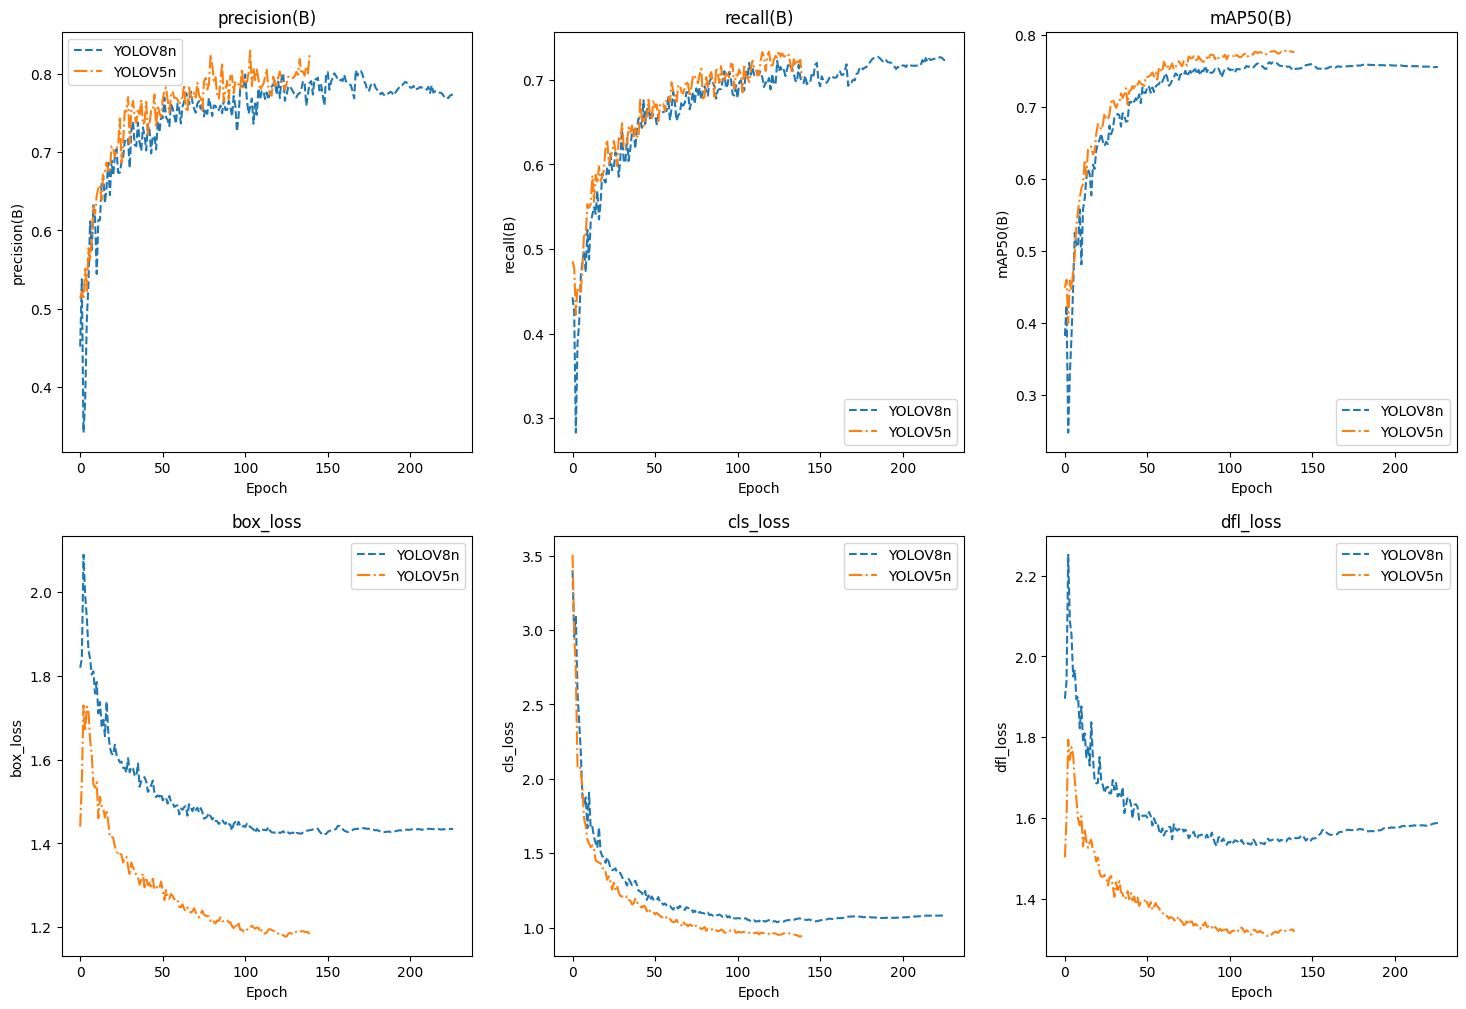

In [38]:
# Переименуем папку с первой моделью
if os.path.isdir('./yolo_cache/detect/train/'):
    os.rename('./yolo_cache/detect/train/', './yolo_cache/detect/train1/')

# Создаём DataFrame с данными о метриках 
metrics = get_metrics()

# Создаём рисунок с вложенными графиками для каждого изображения
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Переменная с индексом метрики
index_column = 0

# Пройдёмся по каждому из вложенных графиков
for x in range(0, 2):
    for y in range(0, 3):
        # Добавим на график данные метрики по каждой из моделей
        for column, style in zip(metrics.iloc[:, index_column::6].columns, ['--', '-.']):
            axes[x, y].plot(metrics[column], style)
        
        # Подпишем название графика и его оси
        axes[x, y].legend([column.split('/')[0] for column in metrics.columns[index_column::6]])
        axes[x, y].title.set_text(metrics.columns[index_column].split('/')[2])
        axes[x, y].set_xlabel('Epoch')
        axes[x, y].set_ylabel(metrics.columns[index_column].split('/')[2])
        
        index_column += 1
fig.savefig('metrics_version_models.png')